In [2]:
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
import numpy as np
import pandas as pd
import scipy.io
from tensorflow import keras as K, nn
import seaborn as sns
from keras.regularizers import l2

2023-12-08 11:39:22.482630: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 11:39:22.867908: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 11:39:22.867968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 11:39:22.869243: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 11:39:22.998390: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-08 11:39:23.000389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Load dataset of our own handwritten letters

In [3]:
# Load all char datasets of own handwriting to create larger dataset
# chars1, chars2, chars3

data1 = np.load('data/training/chars1.npy')
data2 = np.load('data/training/chars2.npy')
data3 = np.load('data/training/chars3.npy')

np.concatenate
data_total = np.concatenate((data1, data2, data3))
data_total.shape

(77, 28, 28)

## Normalize data

In [4]:
data = data_total/255



## Initialized once
# y = np.empty(data.shape[0], dtype=np.uint8)
y = np.array([7,14,15,4,19,7,8,18,22,99,10,18,99,5,11,13,0,15,17,14,9,4,2,19
,19,7,8,18,8,18,0,99,12,15,11,4,99,23,19,19,7,4,99,99,14,13,99,17
,8,15,19,0,19,7,8,17,3,11,8,13,4,99,19,4,23,19,5,8,13,0,11,12
,4,18,18,0,99])

## Labelling data

In [5]:
chars = 'abcdefghijklmnopqrstuvwxyz'
## Unrecognized character gives 99
def encode_char(x):
    try:
        i = chars.index(x)
        return i
    except ValueError:
        return 99

[ 7 14 15  4 19  7  8 18 22 99 10 18 99  5 11 13  0 15 17 14  9  4  2 19
 19  7  8 18  8 18  0 99 12 15 11  4 99 23 19 19  7  4 99 99 14 13 99 17
  8 15 19  0 19  7  8 17  3 11  8 13  4 99 19  4 23 19  5  8 13  0 11 12
  4 18 18  0 99]


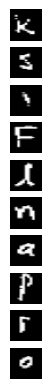

In [6]:
fig, axes = plt.subplots(10)
for i in range(10,20):
    axes[i%10].imshow(data[i,:,:], cmap = "gray")
    axes[i%10].axis('off')

# Manually set labels...
# labels = 'e,-,t,e,x,t,f,i,n,a'.split(',')
# y[60:70] = [encode_char(x) for x in labels]
#print(np.shape(y))
print(y)

## Show data

Char dataset shape:  (77, 28, 28)


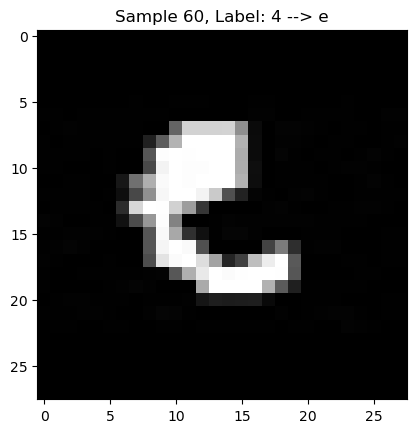

In [7]:
print("Char dataset shape: ", data.shape)
k = np.random.randint(0, len(data))
char = data[k,:,:]
plt.imshow(char, cmap='gray')
label = y[k,]

if label == 99:
    true_char = 'unknown'
else:
    true_char = chars[label]

plt.title('Sample ' + str(k) + ', Label: '+ str(label) + ' --> ' + str(true_char));

# Load EMNIST dataset

In [8]:
emnist = scipy.io.loadmat('data/training/emnist-letters.mat')
emnist_data = emnist['dataset']

X_train = emnist_data['train'][0,0]['images'][0,0]
y_train = emnist_data['train'][0,0]['labels'][0,0]

X_test = emnist_data['test'][0,0]['images'][0,0]
y_test = emnist_data['test'][0,0]['labels'][0,0]

## Create validation set
# val_start = X_train.shape[0] - X_test.shape[0]
# X_val = X_train[val_start:X_train.shape[0],:]
# y_val = y_train[val_start:X_train.shape[0]]
# X_train = X_train[0:val_start,:]
# y_train = y_train[0:val_start]


print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

# print("X validation shape: ", X_val.shape)
# print("y validation shape: ", y_val.shape)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
#y_train = scaler.fit_transform(y_train)
X_test = scaler.fit_transform(X_test)
#y_test = scaler.fit_transform(y_test)

X train shape:  (124800, 784)
y train shape:  (124800, 1)
X test shape:  (20800, 784)
y test shape:  (20800, 1)


Text(0.5, 1.0, 'Test Label: i, 9')

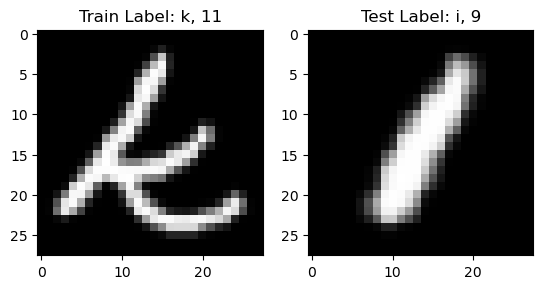

In [9]:
X_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')
X_test = X_test.reshape((X_test.shape[0], 28, 28), order='F')

rand_train = np.random.randint(0, len(X_train))
rand_test = np.random.randint(0, len(X_test))

train_char = X_train[rand_train,:,:]
test_char = X_test[rand_test,:,:]

train_label_i = y_train[rand_train,0]
test_label_i = y_test[rand_test,0]
# Translate labels to letter
letters = 'abcdefghijklmnopqrstuvwxyz'
train_label = letters[train_label_i-1]
test_label = letters[test_label_i-1]

fig, axes = plt.subplots(1,2)
axes[0].imshow(train_char, cmap='gray')
axes[0].set_title(f'Train Label: {train_label}, {train_label_i}')
#plt.title(f'Label: {label}, {label_i}')
axes[1].imshow(test_char, cmap='gray')
axes[1].set_title(f'Test Label: {test_label}, {test_label_i}')

In [10]:
# X_test = X_test.reshape((X_test.shape[0], 28, 28), order='F')

# random_sample = np.random.randint(0, len(X_test))
# char = X_test[random_sample,:,:]
# label_i = y_test[random_sample,0]
# # Translate labels to letter
# letters = 'abcdefghijklmnopqrstuvwxyz'
# label = letters[label_i-1]

# plt.imshow(char, cmap='gray')
# plt.title(f'Label: {label}, {label_i}')



# Pre-training with EMNIST dataset

In [11]:
# Add channel dimension
X_train = X_train.reshape((X_train.shape[0],28,28,1))
X_test = X_test.reshape((X_test.shape[0],28,28,1))


model = K.models.Sequential([
    K.layers.Conv2D(72, (5,5), activation='relu', input_shape=X_train.shape[1:],kernel_regularizer=l2(0.0001)),
    K.layers.MaxPool2D((2,2)),
    K.layers.Conv2D(70, (3,3), activation='relu',kernel_regularizer=l2(0.0001)),
    K.layers.MaxPool2D((2,2)),
    K.layers.Conv2D(68, (3,3), activation='relu',kernel_regularizer=l2(0.0001)),
    K.layers.MaxPool2D((2,2)),
    
    K.layers.Dropout(0.2),
    K.layers.Flatten(),
    K.layers.Dense(145, activation='relu',kernel_regularizer=l2(0.01)),
    K.layers.Dense(len(letters) + 1, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 72)        1872      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 72)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 70)        45430     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 70)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 68)          42908     


2023-12-08 11:39:30.638272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 11:39:31.011830: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 68)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 1, 1, 68)          0         
                                                                 
 flatten (Flatten)           (None, 68)                0         
                                                                 
 dense (Dense)               (None, 145)               10005     
                                                                 
 dense_1 (Dense)             (None, 27)                3942      
                                                                 
Total params: 104157 (406.86 KB)
Trainable params: 104157 (406.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=1000, verbose=2, validation_data=(X_test, y_test))

2023-12-08 11:39:31.968164: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 391372800 exceeds 10% of free system memory.


Epoch 1/10
125/125 - 52s - loss: 2.2154 - accuracy: 0.4927 - val_loss: 1.0691 - val_accuracy: 0.7696 - 52s/epoch - 417ms/step
Epoch 2/10
125/125 - 53s - loss: 1.0039 - accuracy: 0.7669 - val_loss: 0.6986 - val_accuracy: 0.8498 - 53s/epoch - 428ms/step
Epoch 3/10
125/125 - 51s - loss: 0.7466 - accuracy: 0.8198 - val_loss: 0.5733 - val_accuracy: 0.8710 - 51s/epoch - 406ms/step
Epoch 4/10
125/125 - 51s - loss: 0.6203 - accuracy: 0.8458 - val_loss: 0.4726 - val_accuracy: 0.8890 - 51s/epoch - 406ms/step
Epoch 5/10
125/125 - 52s - loss: 0.5499 - accuracy: 0.8593 - val_loss: 0.4336 - val_accuracy: 0.8935 - 52s/epoch - 413ms/step
Epoch 6/10
125/125 - 52s - loss: 0.5029 - accuracy: 0.8685 - val_loss: 0.4093 - val_accuracy: 0.8993 - 52s/epoch - 414ms/step
Epoch 7/10
125/125 - 52s - loss: 0.4732 - accuracy: 0.8749 - val_loss: 0.3835 - val_accuracy: 0.9039 - 52s/epoch - 416ms/step
Epoch 8/10
125/125 - 54s - loss: 0.4512 - accuracy: 0.8807 - val_loss: 0.3649 - val_accuracy: 0.9077 - 54s/epoch - 433

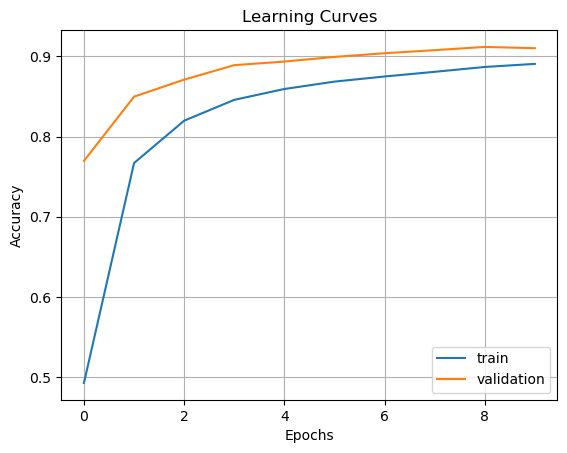

In [20]:
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

In [21]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}')

Accuracy: 91.01923108100891


# Predict our own handwritten characters

In [22]:
data = data.reshape(data.shape[0],28,28,1)
# make prediction
proba = model.predict(data, verbose = 0)
pred = [np.argmax(p) for p in proba]


pred_chars = [chars[x-1] for x in pred]

np.reshape(pred_chars, (1, len(pred_chars)), order='F')
print(pred_chars)


['h', 'o', 'p', 'e', 't', 'h', 'j', 's', 'w', 'm', 'k', 's', 'i', 'f', 'i', 'n', 'a', 'p', 'r', 'o', 'j', 'e', 'e', 't', 't', 'n', 'i', 't', 'i', 's', 'a', 'u', 'm', 'p', 'i', 'e', 'u', 'x', 't', 't', 'h', 'e', 'q', 'm', 'r', 'n', 'e', 'i', 'i', 'p', 't', 'a', 't', 'h', 'i', 'f', 'd', 'i', 'i', 'n', 'e', 'd', 't', 'c', 'x', 't', 'f', 'i', 'n', 'a', 'l', 'm', 'e', 's', 'f', 'a', 's']


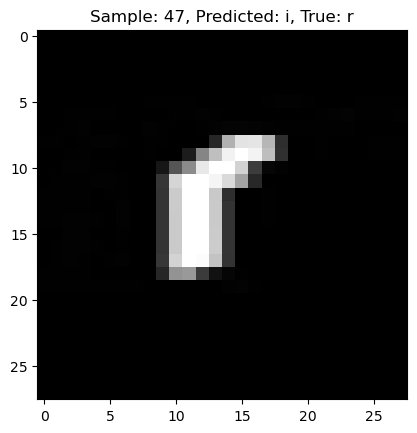

In [23]:
data = data.reshape(data.shape[0],28,28)
k = np.random.randint(0,len(pred_chars))

label = y[k]
if label == 99:
    true_char = 'unknown'
else:
    true_char = chars[label]

plt.imshow(data[k,:,:], cmap='gray')
plt.title(f"Sample: {k}, Predicted: {pred_chars[k]}, True: {true_char}");

## Confusion Matrix

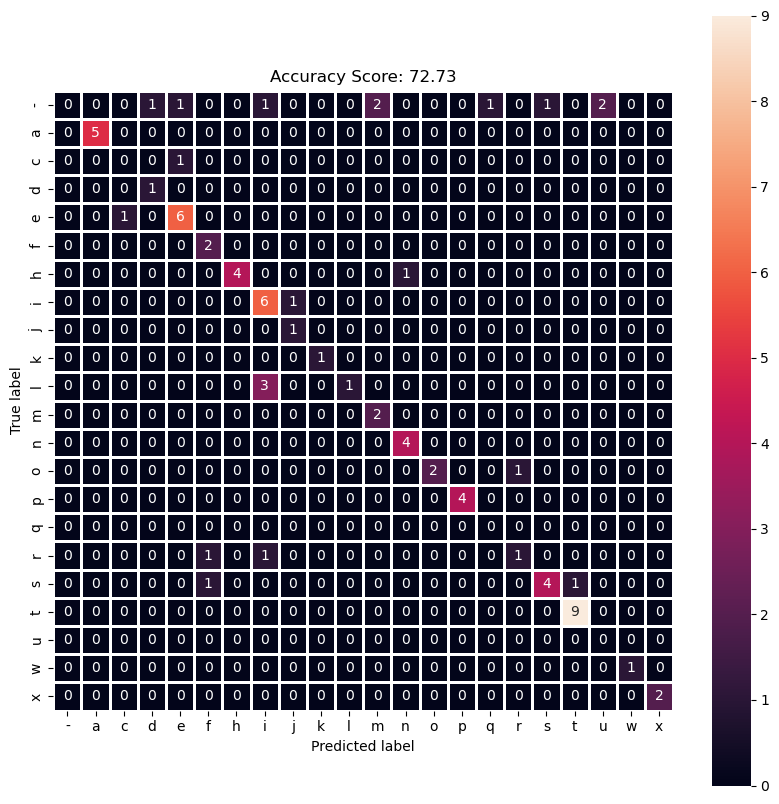

In [24]:
def to_char(index):
    if index == 99:
        return '-'
    else:
        return chars[index]

y_true = [to_char(x) for x in y]
y_pred = pred_chars

## Locate misclassified characters
df = pd.DataFrame(columns=['Pred', 'True'])
df.loc[:,'True'] = y_true
df.loc[:,'Pred'] = y_pred
misclassified = df[df['Pred'] != df['True']]
acc = 1-(len(misclassified)/len(y_pred))

## Confusion matrix
set_total = set(y_pred).union(set(y_true))
labels = sorted(list(set_total))

cm = metrics.confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=1, square=True);
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Accuracy Score: {0:.2f}'.format(acc*100), size=12);
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

In [18]:
print(f"Misclassified: {len(misclassified)}")
misclassified

Misclassified: 21


,Pred,True
6,j,i
9,m,-
12,i,-
14,i,l
22,e,c
25,n,h
27,t,s
31,u,-
34,i,l
36,u,-


In [19]:
## Dictionary with frequency of misclassified characters
dict = {}
for i in range(0,len(misclassified)):
    pred = misclassified.iloc[i,0]
    dict[pred] = dict.get(pred,0) + 1
dict

{'j': 1,
 'm': 2,
 'i': 5,
 'e': 2,
 'n': 1,
 't': 1,
 'u': 2,
 'q': 1,
 'r': 1,
 'f': 2,
 'd': 1,
 'c': 1,
 's': 1}